## 로지스틱 회귀 - 타이타닉 생존자 예측하기
두 가지로 나뉘는 분류(이진 분류) 예측에 사용

### 5.1 문제 정의: 한눈에 보는 예측 목표

### 5.2 라이브러리 및 데이터 불러오기

### 5.3 데이터 확인하기


In [53]:
import pandas as pd
file_url='https://media.githubusercontent.com/media/musthave-ML10/data_source/main/titanic.csv'
data=pd.read_csv(file_url)
data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Embarked,Survived
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,S,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,C,1
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,S,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,S,1
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,S,0


Pclass: 티켓 클래스

SibSp: 함께 탑승한 형제 및 배우자의 수

Parch: 함께 탑승한 부모 및 자녀의 수

Embarked: 승선한 항구

Survived: 생존 유무(1=생존, 0=사망)

독립변수 8개, 종속변수(Survived) 1개

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    889 non-null    int64  
 1   Name      889 non-null    object 
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Ticket    889 non-null    object 
 7   Embarked  889 non-null    object 
 8   Survived  889 non-null    int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 62.6+ KB


결측치 없음.

문자형 변수 4개

In [55]:
data.describe() #통계 정보 확인

,Pclass,Age,SibSp,Parch,Survived
count,889.000000,889.000000,889.000000,889.000000,889.000000
mean,2.311586,29.315152,0.524184,0.382452,0.382452
std,0.834700,12.984932,1.103705,0.806761,0.486260
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,22.000000,0.000000,0.000000,0.000000
50%,3.000000,28.000000,0.000000,0.000000,0.000000
75%,3.000000,35.000000,1.000000,0.000000,1.000000
max,3.000000,80.000000,8.000000,6.000000,1.000000


나이 평균은 약 30살이고, 대부분이 20후반~30초반. 80살까지 있음.

대부분 가족들과 함께 탑승하지 않음.

사망자가 절반이상

p143 출력된 통계 정보의 Pclass변수 하단 회색 박스에'1,2,3 세 가지 클래스가 있다'고 되어있는데 회색 부분을 통해 어떻게 아는지?

**각 변수의 상관관계 확인**

In [56]:
data.corr(numeric_only=True) #교재는 괄호에 조건 없이 data.corr()로 결과 출력함. > maybe 판다스 버전 차이

,Pclass,Age,SibSp,Parch,Survived
Pclass,1.000000,-0.336512,0.081656,0.016824,-0.335549
Age,-0.336512,1.000000,-0.232543,-0.171485,-0.069822
SibSp,0.081656,-0.232543,1.000000,0.414542,-0.034040
Parch,0.016824,-0.171485,0.414542,1.000000,0.083151
Survived,-0.335549,-0.069822,-0.034040,0.083151,1.000000


Parch, SibSp: 가장 큰 상관관계를 보이는 부분 (약 0.41). 가족을 동반할 경우 부모와 자녀, 형제와 배우자를 함께 동반하는 경우가 많을 것이라고 짐작할 수 있음.

0.41 - 중간 수준의 상관관계

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

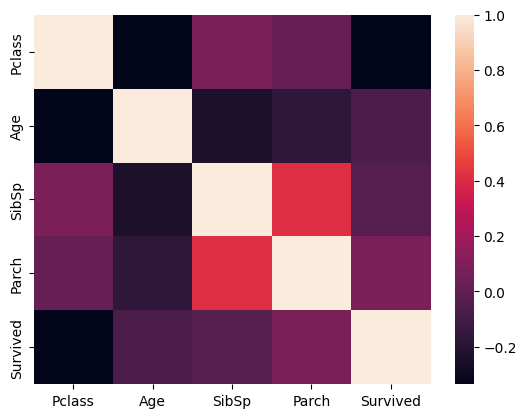

In [58]:
sns.heatmap(data.corr(numeric_only=True)) #상관관계에 대한 히트맵 - 상관관계 파악이 상관관계 테이블보다 용이
plt.show()

0을 기준으로 대칭이 되는 색상을 사용하는 것이 좋음.

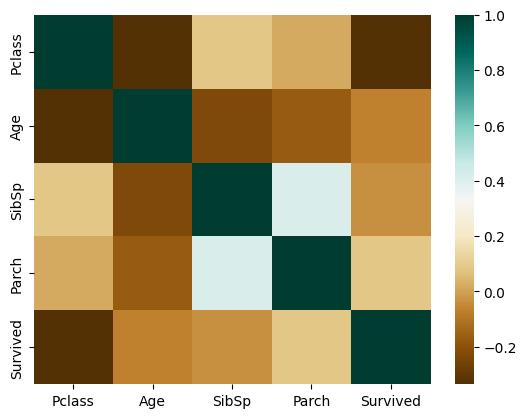

In [59]:
sns.heatmap(data.corr(numeric_only=True),cmap='BrBG') #cmap='coolwarm'!!
plt.show()

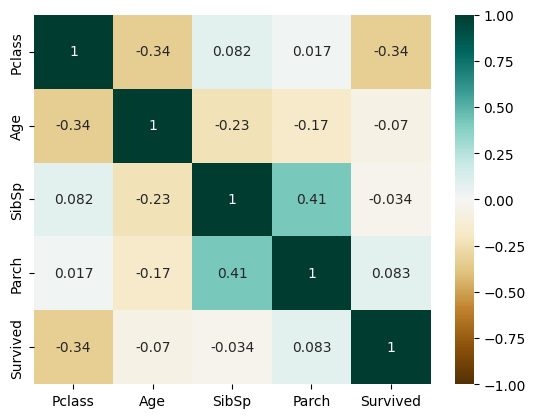

In [60]:
sns.heatmap(
    data.corr(numeric_only=True),
    cmap="BrBG",
    vmin=-1,          # 최소값 (-1)
    vmax=1,           # 최대값 (1)
    annot=True        # 숫자 표시
)
plt.show()

### 5.4 전처리: 범주형 변수 변환하기 ( 더미 변수와 원-핫 인코딩)

object형을 숫자로 대체하는 것 지양 - 숫자가 상대적인 서열로 인식됨
-> 더미 변수 활용!

더미변수와 원-핫 인코딩: 범주 형태(혹은 문자 형태)의 변수를 숫자로 표현하는 방법. 변수에 속해 있는 고윳값에 대한 새로운 변수들을 만들어 0과 1로 표현

값이 수백,수천 가지라면 새로운 컬럼을 수백 수천개 만들기보다는 다른 방법으로 처리.

object형: Name, Sex, Ticket, Embarked 변수

In [61]:
#고윳값 확인
print(data['Name'].nunique())
print(data['Sex'].nunique())
print(data['Ticket'].nunique())
print(data['Embarked'].nunique()) #승선한 항구

889
2
680
3


Name, Ticket 고윳값 수가 많아 더미변수로의 변환에 대해 고민해볼 필요 있음

이름에 따라 사망 여부가 갈린다고 추론하기 어렵기 때문에 제외

티켓 번호는 중요할 수도 있지만, 티켓 클래스 컬럼이 있기 때문에 제외 > 티켓 클래스에 따라 승선 위치가 다르기 때문? 티켓 번호는 더 구체적인 위치가 될 수도 있는거 아닌지?

In [62]:
data=data.drop(['Name','Ticket'],axis=1)
data.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked,Survived
0,3,male,22.0,1,0,S,0
1,1,female,38.0,1,0,C,1
2,3,female,26.0,0,0,S,1
3,1,female,35.0,1,0,S,1
4,3,male,35.0,0,0,S,0


In [63]:
pd.get_dummies(data,columns=['Sex','Embarked']) #Pandas버전 차이로 인해 True/False

,Pclass,Age,SibSp,Parch,Survived,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,0,False,True,False,False,True
1,1,38.0,1,0,1,True,False,True,False,False
2,3,26.0,0,0,1,True,False,False,False,True
3,1,35.0,1,0,1,True,False,False,False,True
4,3,35.0,0,0,0,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...
884,2,27.0,0,0,0,False,True,False,False,True
885,1,19.0,0,0,1,True,False,False,False,True
886,3,28.0,1,2,0,True,False,False,False,True
887,1,26.0,0,0,1,False,True,True,False,False


In [64]:
pd.get_dummies(data,columns=['Sex','Embarked'],dtype=int)

,Pclass,Age,SibSp,Parch,Survived,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,0,0,1,0,0,1
1,1,38.0,1,0,1,1,0,1,0,0
2,3,26.0,0,0,1,1,0,0,0,1
3,1,35.0,1,0,1,1,0,0,0,1
4,3,35.0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
884,2,27.0,0,0,0,0,1,0,0,1
885,1,19.0,0,0,1,1,0,0,0,1
886,3,28.0,1,2,0,1,0,0,0,1
887,1,26.0,0,0,1,0,1,1,0,0


기존 Sex, Embarked변수는 사라지고 각 2,3개 컬럼 생성

컬럼 개수를 줄이면 데이터 계산량이 줄어들기 때문에 더미변수 컬럼 하나씩 빼주는 것이 좋음. 하나를 drop하더라도 구분하는 데에 문제 없음

In [65]:
pd.get_dummies(data,columns=['Sex','Embarked'],dtype=int, drop_first=True)

,Pclass,Age,SibSp,Parch,Survived,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,0,1,0,1
1,1,38.0,1,0,1,0,0,0
2,3,26.0,0,0,1,0,0,1
3,1,35.0,1,0,1,0,0,1
4,3,35.0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...
884,2,27.0,0,0,0,1,0,1
885,1,19.0,0,0,1,0,0,1
886,3,28.0,1,2,0,0,0,1
887,1,26.0,0,0,1,1,0,0


In [66]:
data= pd.get_dummies(data,columns=['Sex','Embarked'],dtype=int, drop_first=True) #최종만 저장

### 5.5 모델링 및 예측하기



훈련셋과 시험셋으로 나눠주기

In [67]:
from sklearn.model_selection import train_test_split

X=data.drop('Survived',axis=1) #종속변수 제거
y=data['Survived'] #종속변수
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

로지스틱 회귀 분석 모듈 불러오기

In [68]:
from sklearn.linear_model import LogisticRegression

In [69]:
model=LogisticRegression()
model.fit(X_train,y_train) #모델 학습

LogisticRegression()

In [70]:
pred=model.predict(X_test) #예측

### 5.6 예측 모델 평가하기

이진분류이기 때문에 RMSE평가 적합하지 않음
이진분류 평가 지표: 정확도, 오차행렬, 정밀도, 재현율, F1 Score, 민감도, 특이도, AUC

정확도 사용 ! - 예측값과 실젯값을 비교하여 얼마나 맞추었는지 확인

In [71]:
from sklearn.metrics import accuracy_score #정확도 라이브러리 임포트
accuracy_score(y_test,pred) #실젯값과 예측값으로 정확도 계산

0.7865168539325843

약 79%정도의 정확도. - not bad but not good

정확도의 좋고 나쁨을 결정하는 절대적인 지표는 없음. 종속변수의 고윳값이 많다면 상대적으로 더 낮은 정확도가 용인됨. 또한 이진분류에서도 고윳값의 비율

In [73]:
model.coef_ #로지스틱 회귀 분석 모델 계수

array([[-1.12329865, -0.03875368, -0.28610903,  0.01760724, -2.50246645,
        -0.29072465, -0.53302887]])

선형회귀분석과 다른 점: 2중 리스트 형태([[]])

In [74]:
pd.Series(model.coef_, index=X.columns) #에러. model.coef_의 길이는 1인데, X.columns의 길이는 7

ValueError: Length of values (1) does not match length of index (7)

In [75]:
len(model.coef_)

1

In [76]:
pd.Series(model.coef_[0], index=X.columns) #인덱싱을 통해 원하는 형태 얻음

,0
Pclass,-1.123299
Age,-0.038754
SibSp,-0.286109
Parch,0.017607
Sex_male,-2.502466
Embarked_Q,-0.290725
Embarked_S,-0.533029


Parch를 제외하고 모두 음수.

Pclass 높을수록 생존 가능성 낮음. 낮을 숫자일수록 더 비싼 티켓

Age는 높을수록 생존 가능성이 낮고, 여성성별(0=female, 1=male)의 생존 가능성이 높음.

### 5.7 이해하기: 피처 엔지니어링

ㄴ 기존 데이터를 손보아 더 나은 변수를 만드는 기법

피처 = 독립변수

다중공선성 - 독립변수 사이에 상관관계가 높을 때 발생하는 문제.
다중공선성 주의하기. - 상관관계가 높은 변수 중 하나를 제거하거나 둘을 모두 포괄시키는 새로운 변수 만들기, PCA(주성분 분석)와 같은 방법으로 차원 축소 수행

**Parch와 SibSp변수를 새로운 변수로 만들기**

In [77]:
data['family'] = data['SibSp'] + data['Parch']
data.drop(['SibSp','Parch'],axis=1, inplace=True)
data.head()

,Pclass,Age,Survived,Sex_male,Embarked_Q,Embarked_S,family
0,3,22.0,0,1,0,1,1
1,1,38.0,1,0,0,0,1
2,3,26.0,1,0,0,1,0
3,1,35.0,1,0,0,1,1
4,3,35.0,0,1,0,1,0


In [78]:
X=data.drop('Survived',axis=1) #종속변수 제거
y=data['Survived'] #종속변수
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
model=LogisticRegression() #모델 생성
model.fit(X_train,y_train) #학습
pred=model.predict(X_test) #예측
accuracy_score(y_test,pred) #실젯값과 예측값으로 정확도 계산

0.7921348314606742

정확도가 0.7865에서 0.7921로 높아짐.

0.4 정도의 상관관계가 있는 변수를 합쳐주면 더 좋은 결과를 얻을 수 있음.

### 5.8 이해하기: 로지스틱 회귀

이진분류에는 왜 선형 회귀 분석을 사용하지 않는가? 0과 1 사이에 있는 값도 직선으로 예측되고, 0과 1 사이에 있지 않은 예측값도 나오게 됨. 로지스틱 회귀 함수를 사용하여 직선 형태를 변형시켜 반올림하여 0과 1 만 가지게 됨.

로지스틱 회귀 분석은 선형 회귀 분석의 공식을 한 번 더 변환한 형태

### 질문



교재에서 '정확도의 좋고 나쁨을 절대적으로 판단할 수 없다'고 나와 있습니다. 정확도가 데이터 클래스 비율에 따라 달라질 수 있는데 주어진 정확도 수치를 가지고 모델 성능을 좋다/나쁘다 판단하는 원리가 잘 이해되지 않습니다. 이 부분에 대한 더 자세한 설명을 듣고 싶습니다.